In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ranksums

# Miscellaneous
AALetter = ['A', 'C', 'D', 'E', 'F', 'G', 'H',
            'I', 'K', 'L', 'M', 'N', 'P', 'Q',
            'R', 'S', 'T', 'V', 'W', 'Y']
features = ["IEP", "Net Charge", "Hydrophobicity", "Hydrophobic Moment",
            "Transmembrane Propensity", "Boman Index", "Aliphatic Index",
            "Alpha Helical Propensity"]


"""
Function for plot mean AA Composition bars
Input:
    data_dict: dictionary of data with categories
Output:
    AA Composition plot with categories and documented mean AAC
"""


def mean_aac_plot(data_dict, dpi=600):

    # mean non-AMP from swissprot/uniprot
    # Classified by Polar Property
    aa_prop = {
        'Hydrophobic': ["A", "I", "L", "M", "V", "F", "W", "Y"],
        'GP': ["G", "P"],
        'Polar(Neutral)': ["N", "C", "Q", "S", "T"],
        'Polar(Acidic)': ["D", "E"],
        'Polar(Alkaline)': ["R", "H", "K"]
    }
    # Colors for categories include Uni-prot

    grid = plt.GridSpec(2, 10, wspace=1.6, hspace=0.22)
    plot_areas = [grid[0, :8], grid[0, 8:],
                 grid[1, :5], grid[1, 5:7], grid[1, 7:]]

    # Get mean AA Composition
    def get_mean_acc(seq_df):
        aac_index = list(map(lambda aa: 'AAC_{}'.format(aa), AALetter))
        return seq_df[aac_index].mean()

    # DataFrame of mean_aac, categories as columns
    categorical_mean_aac = dict(zip(data_dict.keys(), map(get_mean_acc, data_dict.values())))
    categorical_mean_aac = pd.DataFrame(categorical_mean_aac)
    cate_ind = categorical_mean_aac.columns.values.tolist()
    cate_ind = ["{:s}({:d})".format(c, len(itm[1])) for (c, itm) in zip(cate_ind, data_dict.items())]
    # Plot with categorical mean AA Composition
    fig = plt.figure(figsize=(12, 5.8), dpi=dpi)
    b_plots = []
    for prop, ind, p_area in zip(aa_prop.keys(), aa_prop.values(), plot_areas):
        plt.subplot(p_area)
        width, n = 0.18, len(cate_ind)
        total_width = width * n
        x = np.arange(len(ind))
        x = x - (total_width - width) / 2
        count = 0
        b_plots = []
        ind_aa = list(map(lambda aa: 'AAC_{}'.format(aa), ind))
        for cate in categorical_mean_aac:
            if count == 0:
                b_plots.append(plt.bar(x + count * width,
                                       categorical_mean_aac.loc[ind_aa, cate].values,
                                       width=width, label=cate, lw=.8, edgecolor='#000000'))
            else:
                b_plots.append(plt.bar(x + count * width,
                                       categorical_mean_aac.loc[ind_aa, cate].values,
                                       width=width, label=cate, lw=.8, edgecolor='#000000'))
            count += 1
        plt.title(prop)
        plt.xticks(x + total_width / 2, ind)
        plt.ylim([0, 18.5])
        if prop == "Hydrophobic" or prop == "Polar(Neutral)":
            plt.ylabel("Mean AAC (%)")
    fig.legend(b_plots, cate_ind,
               loc="lower center", ncol=len(cate_ind))
    #fig.suptitle("Mean AAC of dataset", fontsize='x-large')
    return fig, categorical_mean_aac


def euclidean_measure(a, b, sqrt=True, normalize=True):
    if normalize:
        a = (a - a.min(axis=0)) / (a.max(axis=0) - a.min(axis=0))
        b = (b - b.min(axis=0)) / (b.max(axis=0) - b.min(axis=0))
    aTa = np.diag(np.matmul(a, a.T))
    bTb = np.diag(np.matmul(b, b.T))
    aTb = np.matmul(a, b.T)
    D = aTa.reshape(-1, 1) - 2.0 * aTb + bTb.reshape(1, -1)
    if sqrt:
        D = np.sqrt(D)
    return D


"""
Function for visualize the feature selection results
Input:
    cnt_slt: counted features after feature selection, dictionary.
    cnt_all: counted features before feature selection, dictionary
    df_fs: data_frame for p-value
Output:
    ind_selected: selected features
"""


def visualize_fs(df_pvalue, features_categories, dpi=600):
    fig = plt.figure(figsize=(8, 4), dpi=dpi)
    grid = fig.add_gridspec(51, 10)
    ax = [fig.add_subplot(gs) for gs in [grid[:31, :5], grid[:31, 4:], grid[30:, :]]]
    # Create color-dict
    colors = {'AAC': '#1E90FF', 'DiC': '#FDD835', 'gap': '#7FFFD4', 'Xc': '#FF1493', 'PHYC': '#32CD32'}
    # Get count_all from df_palue
    features_inds = df_pvalue['Feature']
    count_all = {fc: len(list(filter(lambda x: True if fc in x else False, features_inds)))
                   for fc in features_categories[:-1]}
    count_all[features_categories[-1]] = len(features_inds) - sum(count_all.values())
    # Get count_selected from df_pvalue
    selected_inds = df_pvalue[df_pvalue['pvalue']<0.05]['Feature']
    count_selected = {fc: len(list(filter(lambda x: True if fc in x else False, selected_inds)))
                       for fc in features_categories[:-1]}
    count_selected[features_categories[-1]] = len(selected_inds) - sum(count_selected.values())
    count_selected = dict(sorted(count_selected.items(), key=lambda x: x[1], reverse=True))
    
    sorted_cnt, sorted_ind = list(count_selected.values()), list(count_selected.keys())
    sum_cnt_slt = sum(sorted_cnt)
    oflab = {"Xc": "PAAC", "AAC":"AAC", "gap": "CKSAAGP", "PHYC": "PHYC", "DiC": "DiC"}
    labels_cnt = ["{:s}({:.1f}%)".format(oflab[fc], count_selected[fc] * 100 / sum_cnt_slt) for fc in sorted_ind]
    wedges, _ = ax[0].pie(sorted_cnt, colors=[colors[fc] for fc in count_selected.keys()],
                          wedgeprops=dict(width=0.4, edgecolor='k'))
    ax[0].set_position([0.14, 0.5, 0.45, 0.45])
    ax[0].legend(wedges, labels_cnt, title='Features', loc="center left", bbox_to_anchor=(-.76, .08, .8, 1),
                 fontsize='small')
    ax[0].set_title('(a)')
    ratio = {fc: count_selected[fc] / count_all[fc] for fc in features_categories}
    ratio = dict(sorted(ratio.items(), key=lambda x: x[1]))
    ax[1].barh([oflab[fc] for fc in list(ratio.keys())], list(ratio.values()), height=.6, edgecolor='k',
               color=[colors[fc] for fc in ratio.keys()])
    ax[1].invert_xaxis()
    ax[1].yaxis.tick_right()
    ax[1].xaxis.tick_top()
    ax[1].set_xlim([1, 0])
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_position([0.46, 0.56, 0.4, 0.3])
    ax[1].set_title('(b)')

    df_ind = df_pvalue.copy()
    df_ind["Feature_type"] = np.concatenate([["AAC"] * 20, ['DiC'] * 400, ['gap'] * 75, ['Xc'] * 24, ['PHYC'] * 8])
    df_ind['logp'] = -np.log10(df_ind['pvalue'])
    df_ind = df_ind.sort_values(by=['logp'], ascending=False)
    df = df_ind.iloc[:80, :]
    ax[2].bar(np.arange(80), df['logp'], color=[colors[fc] for fc in df['Feature_type']], width=.8)
    ax[2].set_xlim([-1, 81])
    ax[2].xaxis.set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].set_ylabel('$-\lg$(pvalue)')
    ax[2].set_ylim([0, 60])
    ax[2].set_position([0.12, 0.3, 0.8, 0.24])
    ax[2].set_title('(c)', loc='center')

    return fig

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

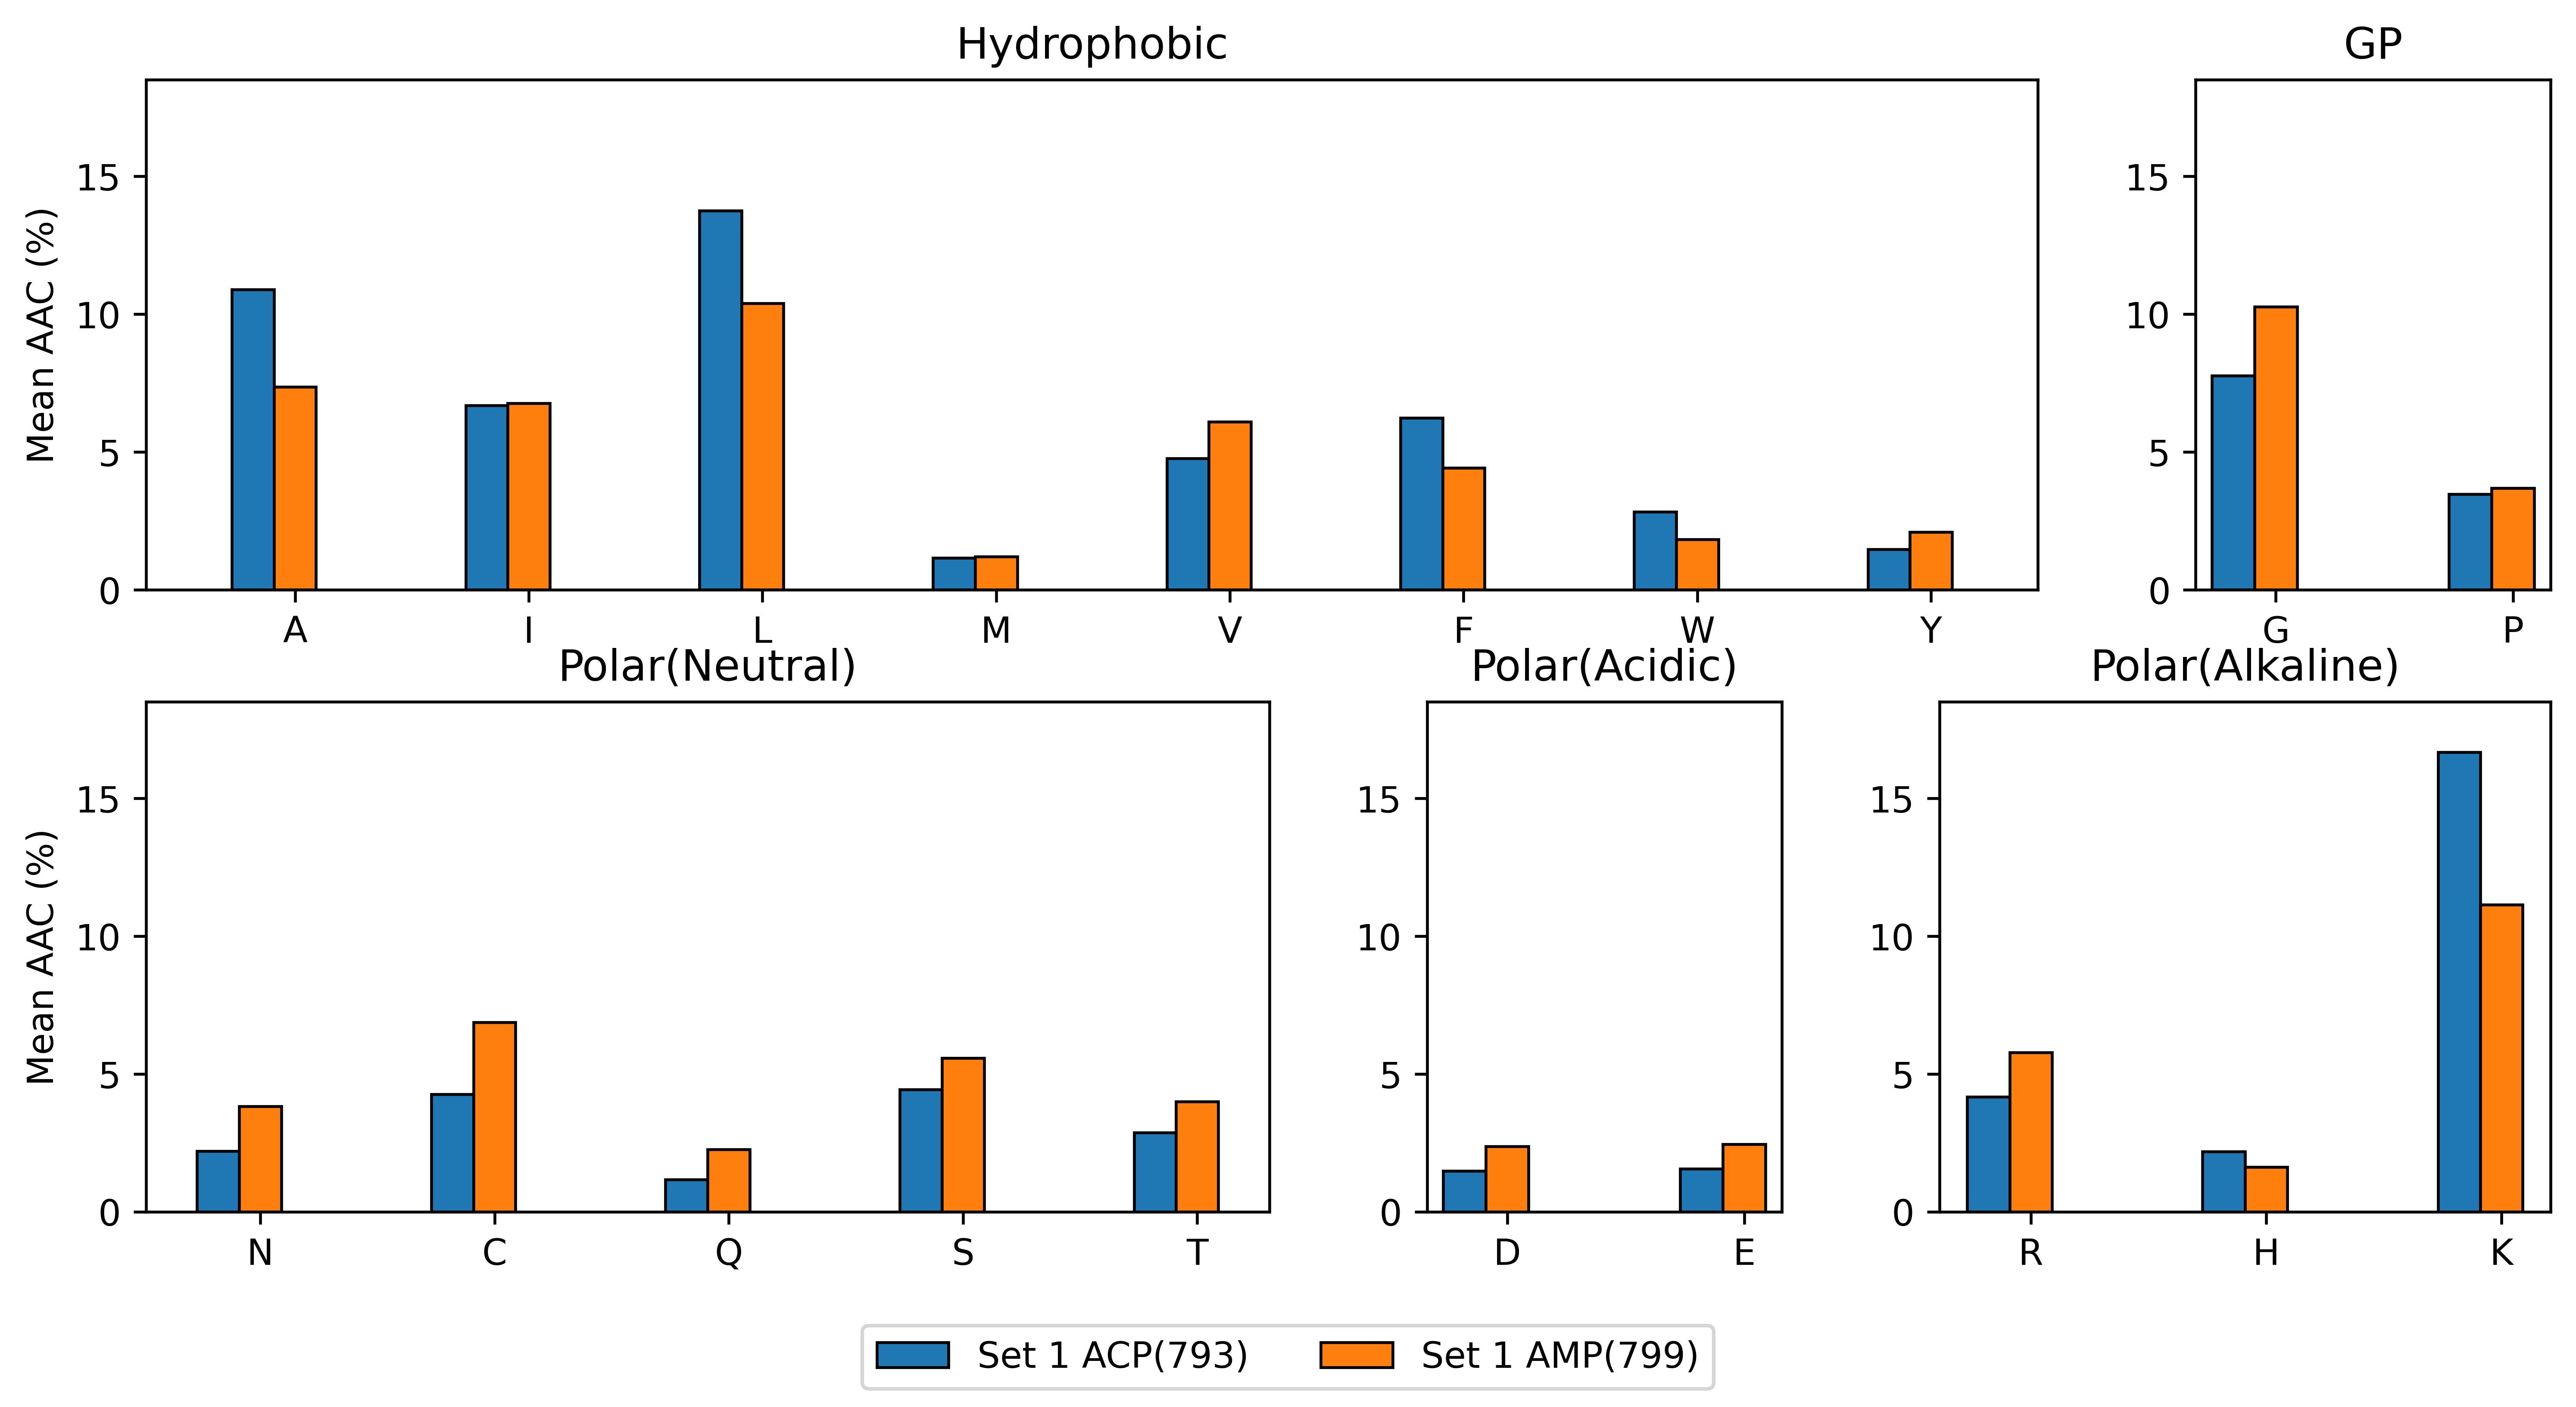

In [3]:
amp_sets = {
    "Set 1 ACP": pd.read_csv("main/positive.csv"),
    "Set 1 AMP": pd.read_csv("main/negative.csv")
}
aac_plot_set1, mean_aac = mean_aac_plot(amp_sets)

Set 1 ACP


/home/yaolt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yaolt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Set 1 AMP


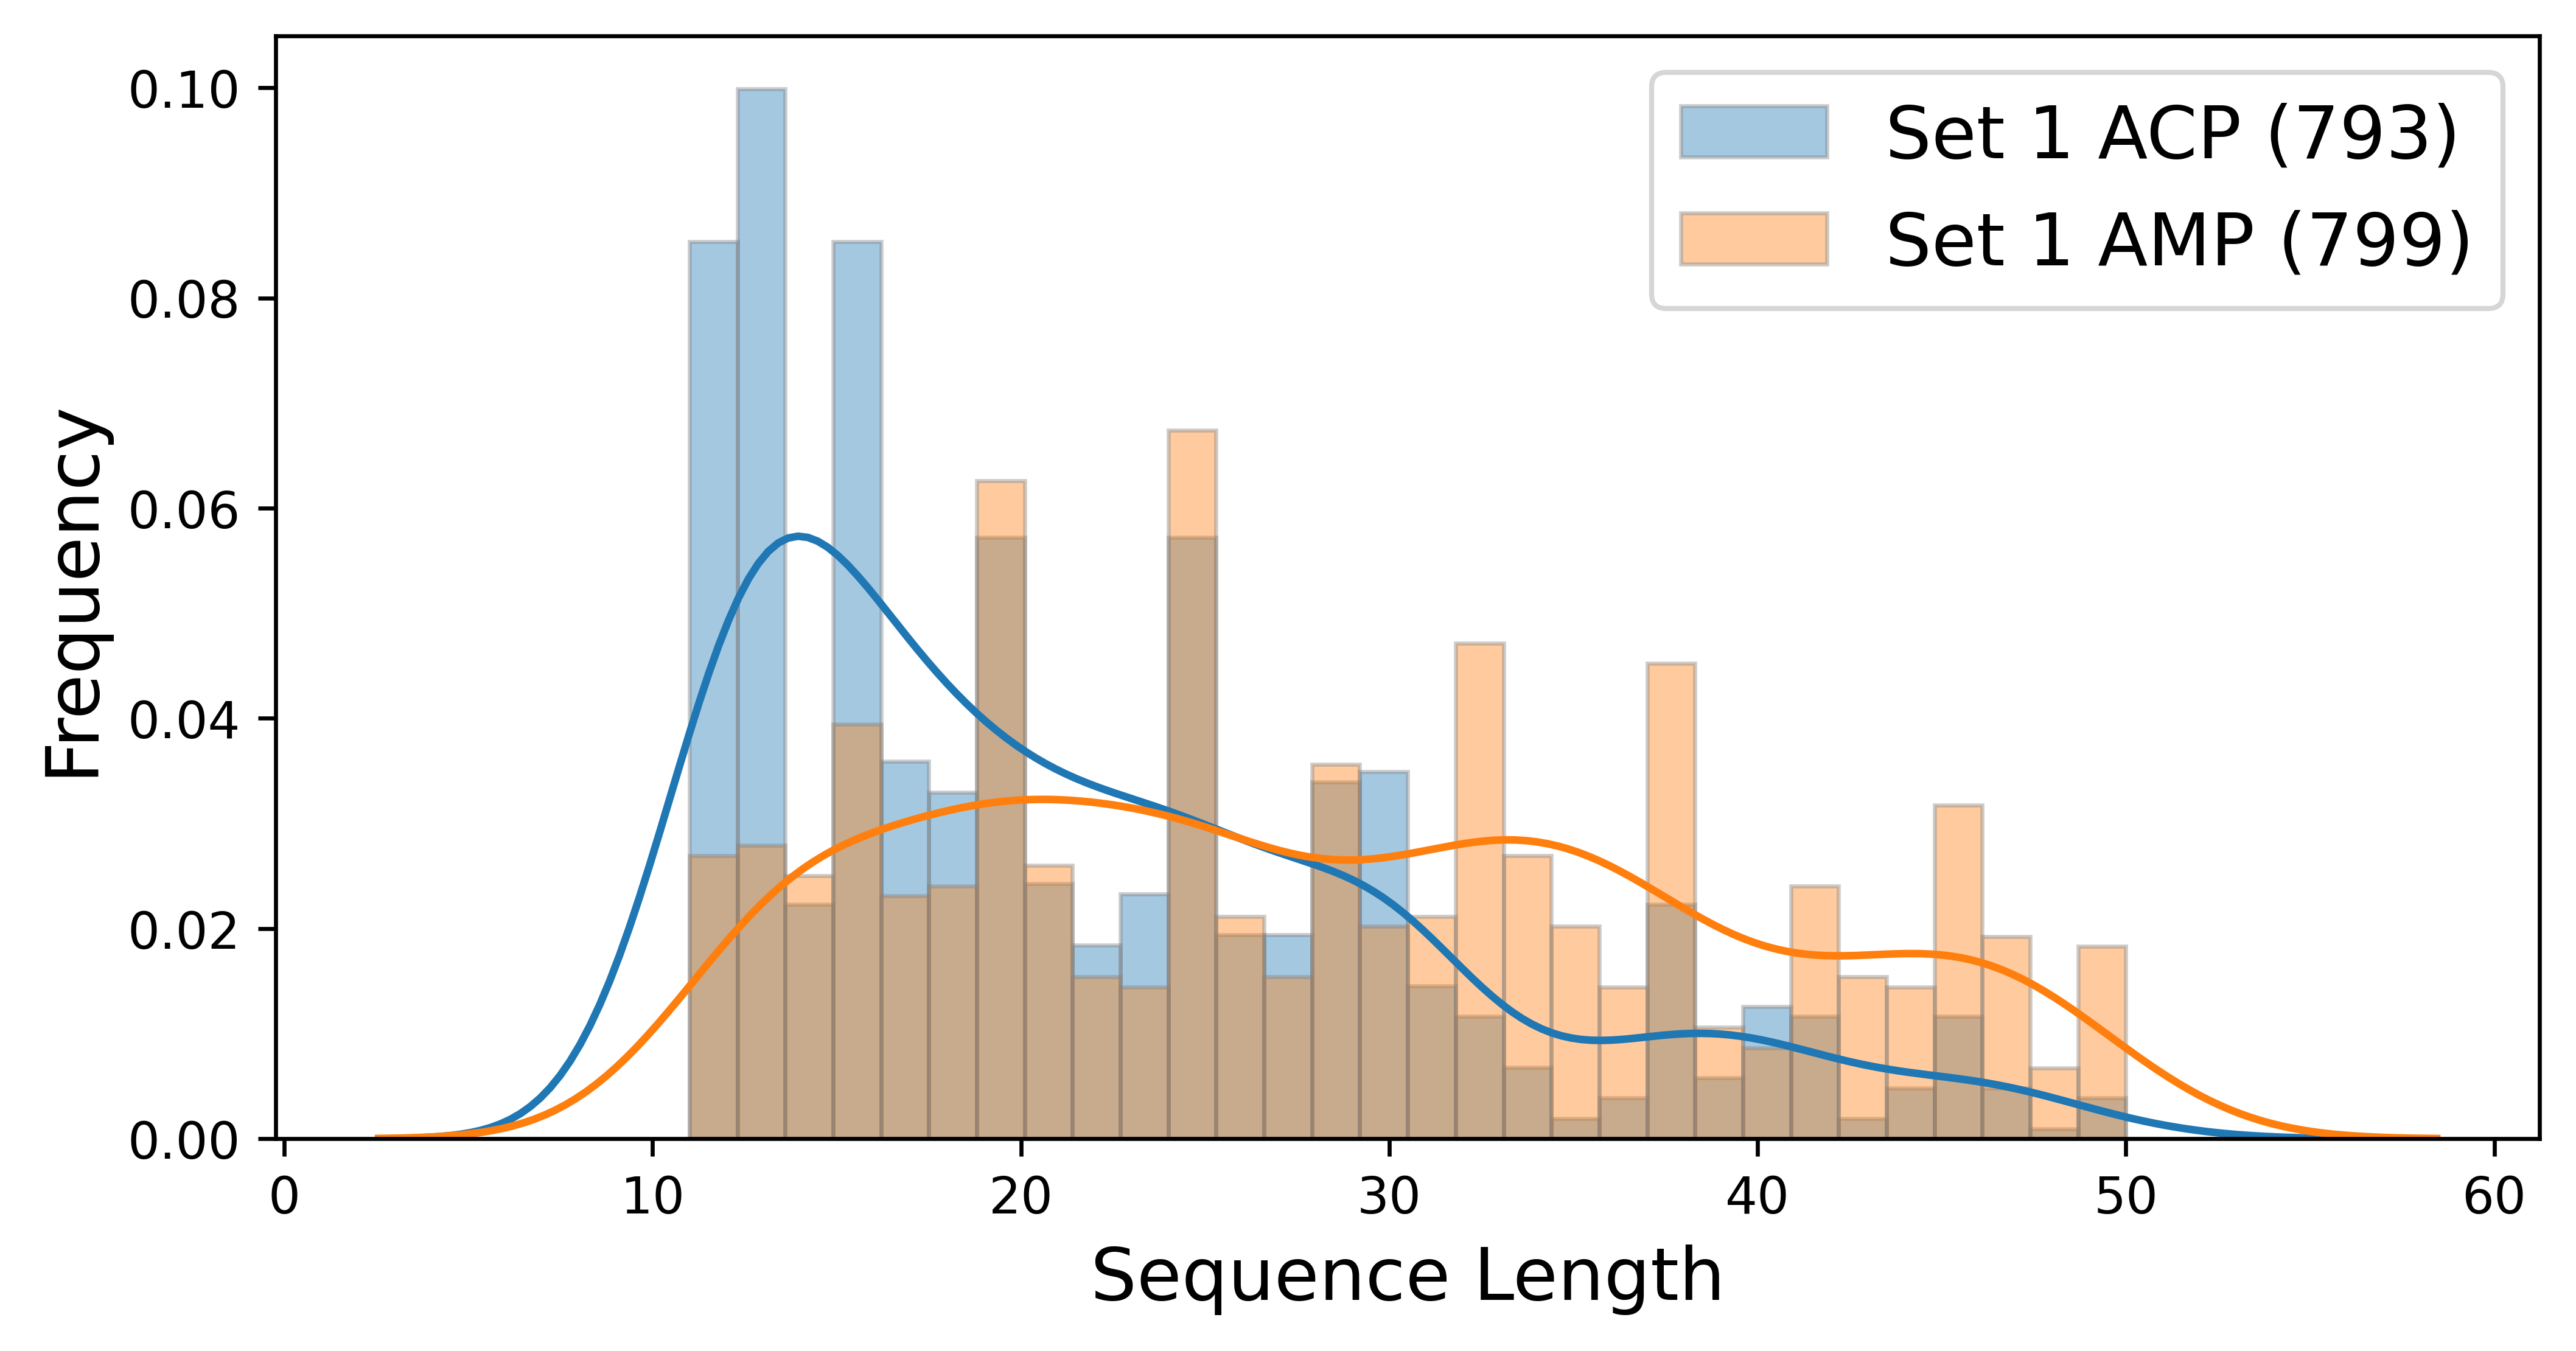

In [4]:
lengthfig = plt.figure(figsize=(8, 4), dpi=600)
for set_name, df in amp_sets.items():
    print(set_name)     
    seqs_length = df['Sequence'].str.len()
    sns.distplot(seqs_length, bins=30, label="{:s} ({:d})".format(set_name, len(df)), rug=False, kde=True,hist_kws=dict(edgecolor="#808080", linewidth=.8))

plt.xlabel("Sequence Length", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
lgd = plt.legend(fontsize='x-large')